In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint
import pickle

from utils import utils, files # sibling package...

In [2]:
experiment = "emg_olympics"
subject = "peter"
path_dictionary = files.build_experiment_path_dict(experiment)
subject_metadata_folder = utils.get_subject_folder(experiment,subject)

data folder:  /mnt/c/Users/spencer/data/emg_olympics


bars
- variance compared to movements
- explained by movements?
- height of target bar vs height of other bars? (some type of score)
- "shape" of bar data overall? 
  - dimensionality
  - ...?
- search strategy (dynamical modes?)

targets
- dimensionality
- search strategy
- comparison to natural movements (what movements are you making per target?)

/tmp/ipykernel_463/3707757827.py:38: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


andy -- Intercept: 33.55500212331665 | Rate: 9.439014775469841 | Hit Fraction: 0.5111111111111111


/tmp/ipykernel_463/3707757827.py:38: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


peter -- Intercept: 2.767776459584994 | Rate: 28.13219468723921 | Hit Fraction: 0.7277777777777777
miranda -- Intercept: 15.246072733579032 | Rate: 18.63011235703089 | Hit Fraction: 0.687037037037037
bob -- Intercept: 2.1747459688872453 | Rate: 24.669862965881833 | Hit Fraction: 0.7296296296296296


/tmp/ipykernel_463/3707757827.py:38: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_463/3707757827.py:38: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


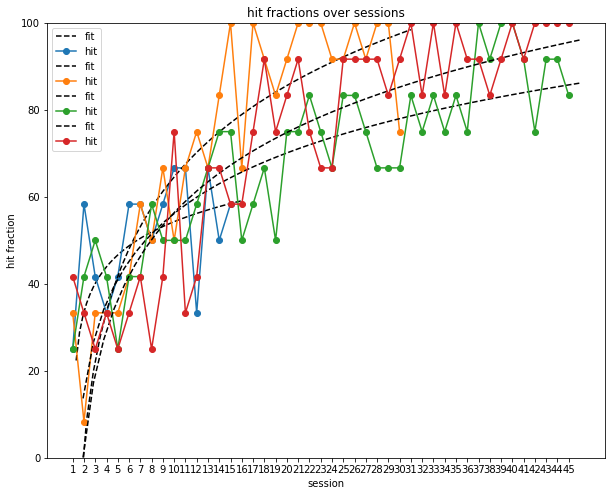

In [3]:
def get_outcomes(subject):
    session_dict = path_dictionary["subjects"][subject]["tasks"]["center_hold"]["sessions"]
    session_path_list = []

    for session in sorted(list(session_dict.keys()),key=lambda x: int(x.split("_")[-1])):
        session_path_list.append(session_dict[session])
    num_sessions = len(session_path_list)
    hits = []
    misses = []
    noholds = []
    reach_times = []
    for behavior_path in session_path_list:
        outcome_path = [x for x in behavior_path.iterdir() if "result" in x.name][0]
        behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
        outcomes = [x[0] for x in behavior]
        for x in behavior:
            if x[0] == "Hit":
                reach_times.append(x[2])
        uniques, counts = np.unique(outcomes, return_counts=True)
        for outcome, count in zip(uniques, counts):
            if outcome == "Hit":
                hits.append(count)
            elif outcome == "Miss":
                misses.append(count)
            elif outcome == "No Hold":
                noholds.append(count)
            else:
                raise ValueError("Unforeseen outcome in behavior: ", outcome)
        if "Hit" not in outcomes:
            hits.append(0)
        if "Miss" not in outcomes:
            misses.append(0)
        if "No Hold" not in outcomes:
            noholds.append(0)
    return hits, misses, noholds, num_sessions

def func(x, a, b):
    return b * np.log(x) + a
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1,1,figsize=(10,8))
for subject in ["andy", "peter", "miranda", "bob"]:
    hits, misses, noholds, num_sessions = get_outcomes(subject)
    fractions = [h*(100/12) for h in hits]
    sessions_idxs = range(len(fractions))
    x = np.linspace(0,num_sessions,50)
    popt, pcov = curve_fit(func, list(range(1, num_sessions+1)), fractions)
    plt.plot(x, func(x, *popt), 'k--', label="fit")
    total_fraction = sum(hits)/(num_sessions*12)
    print(f"{subject} -- Intercept: {popt[0]} | Rate: {popt[1]} | Hit Fraction: {total_fraction}")
    ax.plot(fractions , "-o", label="hit")
    # ax.plot([m*(100/12) for m in misses] , "g-o", label="miss")
    # ax.plot([n*(100/12) for n in noholds] , "b-o", label="no hold")
ax.set_xlabel("session")
ax.set_ylabel("hit fraction")
ax.set_title("hit fractions over sessions")
ax.set_ylim([0,100])
ax.set_xticks(range(num_sessions))
ax.set_xticklabels(range(1,num_sessions+1))
ax.legend()

## reach variance

## load data

In [4]:
experiment = "emg_olympics"
subject = "peter"

movement_session = "1"
calibration_session = "0"
center_hold_session = None # check manually for a folder, default to the first one

subject_metadata_folder = utils.get_subject_folder(experiment=experiment, subject=subject)
assert subject_metadata_folder.exists()
print("subject metadata: ", subject_metadata_folder)

subject metadata:  /mnt/c/Users/spencer/Documents/kyberphysics/metadata/emg_olympics/peter


In [ ]:
if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

In [ ]:
if not center_hold_session is None:
    concat_center_hold_data = utils.concat_emg_trials(chd)[:,:64]
    concat_center_hold_data = analysis.highpass(concat_center_hold_data,cutoff=high_cutoff)
    print(concat_center_hold_data.shape)
    center_hold_vars = np.std(concat_center_hold_data, axis=0)
    center_hold_means = np.mean(concat_center_hold_data, axis=0)

(64, 1)


In [ ]:
if not center_hold_session is None:
    plt.figure()
    hp = concat_center_hold_data[start:stop]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

(64, 1)


In [ ]:
if not center_hold_session is None:
    standardized_center_hold_data = utils.standardize(concat_center_hold_data, calibration_vars)
    filtered_center_hold_data = utils.filter_emg(standardized_center_hold_data)
    offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
    plt.plot(standardized_center_hold_data[:end,channel])
    plt.plot(filtered_center_hold_data[:end,channel])
    plt.plot(offset_center_hold_data[:end,channel],label="offset")
    if end == -1:
        plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
    else:
        plt.plot([0,end],[0,0])
    plt.legend()

In [ ]:
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)

# 2D preview
fig, axes = plt.subplots(2,1)
for ax, c in zip(axes,decoder[-2:]):
    baseline = np.dot(c,filtered_movement_data.T)
    ax.plot(baseline)
    baseline = np.dot(c,offset_movement_data.T)
    ax.plot(baseline,label="offset")
    ax.plot([0,baseline.shape[0]],[0,0])
    ax.legend()

# PCA

In [ ]:
# get components -- channel-wise covariance
num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(filtered_calibration_data)
pca_components = pca_model.components_
print(pca_components.shape)

In [ ]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))
plt.plot(movement_vars)

In [ ]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

# factor analysis

https://stackoverflow.com/questions/37221635/rotation-argument-for-scikit-learns-factor-analysis
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html#sphx-glr-auto-examples-decomposition-plot-varimax-fa-py
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
https://scikit-learn.org/stable/modules/decomposition.html#fa

In [ ]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

In [ ]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))